In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate

import tensorflow as tf
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau


2023-09-17 02:39:50.341675: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-17 02:39:50.910410: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# **Data loading and preprocessing**

In [4]:
images = []
masks = []

dataset_dir = "brain-tumor-dataset/Images"

for image in sorted(os.listdir(dataset_dir)):
    images.append(Image.open(os.path.join(dataset_dir, image)))

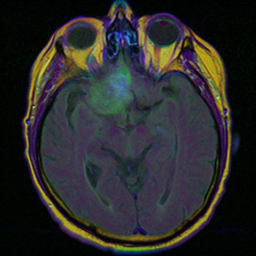

In [5]:
images[10]

In [6]:
dataset_dir = "brain-tumor-dataset/Masks"

for image in sorted(os.listdir(dataset_dir)):
    masks.append(Image.open(os.path.join(dataset_dir, image)))

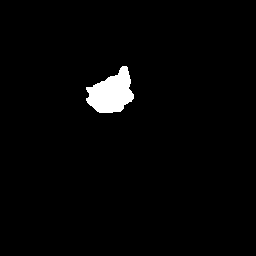

In [7]:
masks[10]

### Split into training and validation sets

In [8]:
split = int(np.ceil(len(images) * 0.8))

train_images = images[:split]
val_images = images[split:]

train_masks = masks[:split]
val_masks = masks[split:]

In [9]:
len(train_images), len(val_images), len(train_masks), len(val_masks)

(3128, 781, 3128, 781)

### Create Data generator

In [10]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator as KerasImageDataGenerator
import random

class ImageDataGenerator(Sequence):
    def __init__(self, images, masks, batch_size, image_size):
        self.images = images
        self.masks = masks
        self.batch_size = batch_size
        self.image_size = image_size

        self.data_augmenter = KerasImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_image_filenames = self.images[idx * self.batch_size: (idx + 1) * self.batch_size]
        batch_mask_filenames = self.masks[idx * self.batch_size: (idx + 1) * self.batch_size]

        batch_images = []
        batch_masks = []

        for image_filename, mask_filename in zip(batch_image_filenames, batch_mask_filenames):

            image = image_filename.resize(self.image_size)
            mask = mask_filename.resize(self.image_size)

            image = np.array(image) / 255
            mask = np.array(mask) / 255

            expanded_mask = np.expand_dims(mask, axis=-1)
            # Stack the expanded array with itself along the third axis to create a (112, 112, 3) array
            mask = np.concatenate([expanded_mask] * 3, axis=-1)
            
            seed = 23

            augmented = self.data_augmenter.random_transform(image, seed=seed)
            image = augmented

            augmented = self.data_augmenter.random_transform(mask, seed=seed)
            mask = augmented

            batch_images.append(image)
            batch_masks.append(mask)

        return np.array(batch_images), np.array(batch_masks)


In [11]:
batch_size = 4
image_size = (112, 112)

train_data_gen = ImageDataGenerator(train_images, train_masks, batch_size, image_size)
val_data_gen = ImageDataGenerator(val_images, val_masks, batch_size, image_size)

In [12]:
train_data_gen[0][1][0].shape, len(train_data_gen), len(val_data_gen)

((112, 112, 3), 782, 196)

# **Data Visualization**

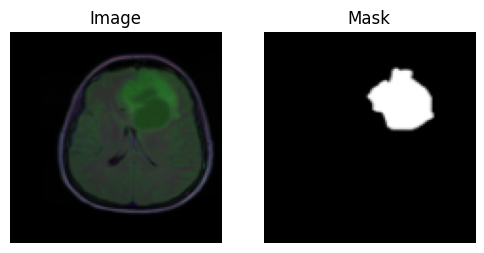

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(6, 8))

axs[0].imshow(val_data_gen[80][0][0])
axs[0].set_title('Image')

axs[1].imshow(val_data_gen[80][1][0])
axs[1].set_title('Mask')

for ax in axs:
    ax.axis('off')

plt.show()

# **MODELING**

In [14]:
def unet_model(input_shape):
    inputs = Input(input_shape)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
        
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
        
    # Mid-level
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    drop3 = Dropout(0.5)(conv3)
        
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(drop3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D((2, 2))(drop4)
    
    # Decoder
    upconv1 = UpSampling2D(size=(2, 2))(pool4)
    upconv1 = Conv2D(128, 2, activation='relu', padding='same')(upconv1)
    merge1 = concatenate([conv3, upconv1], axis=3)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(merge1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)
        
    upconv2 = UpSampling2D(size=(2, 2))(conv4)
    upconv2 = Conv2D(64, 2, activation='relu', padding='same')(upconv2)
    merge2 = concatenate([conv2, upconv2], axis=3)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(merge2)
        
    upconv3 = UpSampling2D(size=(2, 2))(conv5)
    upconv3 = Conv2D(64, 2, activation='relu', padding='same')(upconv3)
    merge3 = concatenate([conv1, upconv3], axis=3)
    conv6 = Conv2D(64, 3, activation='relu', padding='same')(merge3)
        
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv6)
    
    outputs = Conv2D(1, 1, activation='sigmoid')(conv7)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [15]:
input_shape = train_data_gen[0][0][0].shape
model = unet_model(input_shape)

2023-09-17 02:39:53.389195: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-17 02:39:53.408746: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-17 02:39:53.409184: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### Defining custom metrics

In [ ]:
def dice_coefficient_metric(y_true, y_pred, smooth=1.0):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

def jaccard_index_metric(y_true, y_pred, smooth=1.0):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    jaccard = (intersection + smooth) / (union + smooth)
    return jaccard


model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy', dice_coefficient_metric, jaccard_index_metric])

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 112, 112, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 112, 112, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 56, 56, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

# **Load model**

In [17]:
# # LOADING MODEL
# model_path = r'model_checkpoints/best_model_epoch_31_loss_0.0097.h5'  # Replace with your actual model path
# model.load_weights(model_path)

# **Training**

In [27]:
# from tensorflow.keras.callbacks import ModelCheckpoint

# class CustomModelCheckpoint(ModelCheckpoint):
#     def __init__(self, **kwargs):
#         super().__init__(**kwargs)

#     def on_epoch_end(self, epoch, logs=None):
#         logs = logs or {}
#         val_loss = logs.get(self.monitor)
#         if val_loss is None:
#             return
        
#         self.filepath = f"model_checkpoints/best_model_epoch_{epoch:02d}_loss_{val_loss:.4f}.h5"
#         super().on_epoch_end(epoch, logs)


# checkpoint_callback = CustomModelCheckpoint(
#     filepath=None,          # This will be overwritten by `on_epoch_end` in `CustomModelCheckpoint`
#     save_weights_only=True,
#     save_best_only=True,
#     monitor='val_loss',
#     verbose=1,
#     mode='min'
#     )

### Callbacks

*Checkpoint callback*

In [17]:
checkpoint = ModelCheckpoint(
    "unet_checkpoint.h5",  # Filepath to save the model weights
    monitor="val_loss",  # Monitor validation loss
    save_best_only=True,  # Save only the best model
    mode="min",  # Minimize validation loss
    verbose=1,  # Verbosity level (optional)
    save_weights_only=True,  # Save only the weights, not the entire model (optional)
)

*Early stopping callback*

In [18]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=8, restore_best_weights=True, verbose=1
)

*Learning rate scheduler*

In [19]:
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",  # Monitor validation loss
    factor=0.5,  # Reduce learning rate by half
    patience=3,  # Number of epochs with no improvement
    min_lr=1e-7,  # Minimum learning rate (optional)
    verbose=1,  # Verbosity level (optional)
)

In [20]:
epochs = 1000

history = model.fit(
    train_data_gen,
    validation_data=val_data_gen,
    epochs=epochs,
    verbose=1,
    callbacks=[checkpoint, early_stopping, reduce_lr]
    )

Epoch 1/1000


2023-09-17 02:40:11.356847: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-09-17 02:40:11.574376: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-17 02:40:11.644995: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-17 02:40:12.026365: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-09-17 02:40:12.046642: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7efdd875e570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-17 02:40:12.046685: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0

781/782 [============================>.] - ETA: 0s - loss: 0.0619 - accuracy: 0.9843 - dice_coefficient_metric: 0.0746 - jaccard_index_metric: 0.0497
Epoch 1: val_loss improved from inf to 0.02522, saving model to unet_checkpoint.h5
782/782 [==============================] - 43s 46ms/step - loss: 0.0618 - accuracy: 0.9843 - dice_coefficient_metric: 0.0745 - jaccard_index_metric: 0.0497 - val_loss: 0.0252 - val_accuracy: 0.9892 - val_dice_coefficient_metric: 0.1154 - val_jaccard_index_metric: 0.0859 - lr: 1.0000e-04
Epoch 2/1000
781/782 [============================>.] - ETA: 0s - loss: 0.0329 - accuracy: 0.9853 - dice_coefficient_metric: 0.1672 - jaccard_index_metric: 0.1171
Epoch 2: val_loss did not improve from 0.02522
782/782 [==============================] - 35s 45ms/step - loss: 0.0328 - accuracy: 0.9853 - dice_coefficient_metric: 0.1671 - jaccard_index_metric: 0.1171 - val_loss: 0.0258 - val_accuracy: 0.9908 - val_dice_coefficient_metric: 0.2048 - val_jaccard_index_metric: 0.175

# **Model Evaluation**

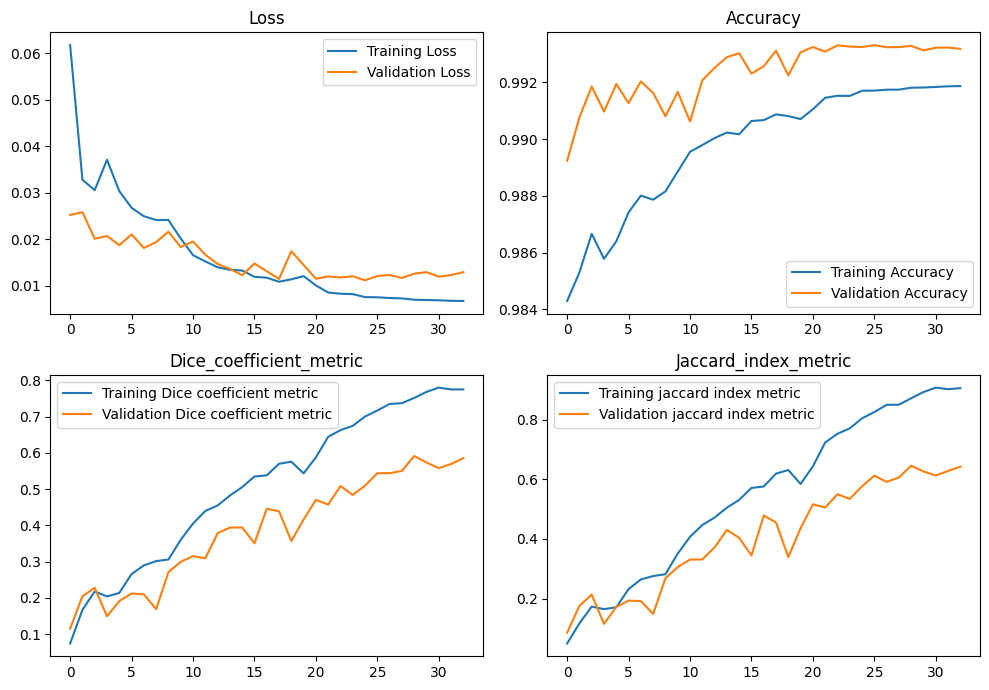

In [46]:
plt.figure(figsize=(10,7))

plt.subplot(221)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(222)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(223)
plt.plot(history.history['dice_coefficient_metric'], label='Training Dice coefficient metric')
plt.plot(history.history['val_dice_coefficient_metric'], label='Validation Dice coefficient metric')
plt.title('Dice_coefficient_metric')
plt.legend()

plt.subplot(224)
plt.plot(history.history['jaccard_index_metric'], label='Training jaccard index metric')
plt.plot(history.history['val_jaccard_index_metric'], label = 'Validation jaccard index metric')
plt.title('Jaccard_index_metric')
plt.legend()

plt.tight_layout()
plt.show()

In [47]:
loss, accuracy, dice_coefficient_metric, jaccard_index_metric = model.evaluate(val_data_gen, verbose=0)
print("Loss: ", loss, "\nAccuracy: ", accuracy, "\nDice Coefficient: ", dice_coefficient_metric, "\nJaccard Index: ", jaccard_index_metric)

Loss:  0.011159580200910568 
Accuracy:  0.9932454824447632 
Dice Coefficient:  0.5097473859786987 
Jaccard Index:  0.5767109394073486


# **Prediction**

In [48]:
# PREDICT ON A BATCH OF IMAGES

preds = model.predict(val_data_gen, verbose=0)

# Create an OpenCV window
window_name = "Image Sequence"
cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)

for image in preds:
    cv2.imshow(window_name, image)
    
    # Wait for a specific time (in milliseconds) or press a key to continue
    key = cv2.waitKey(10)
    
    # Exit the loop if the 'Esc' key is pressed
    if key == 27:
        break

# Close the OpenCV window
cv2.destroyAllWindows()


In [49]:
preds.shape

(781, 112, 112, 1)

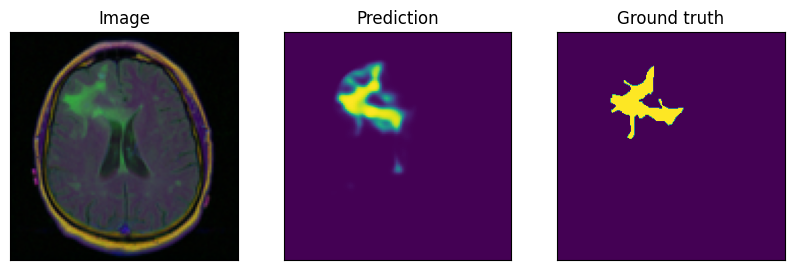

In [55]:
# PREDICT SINGLE IMAGE

image = r'brain-tumor-dataset/Images/015.tif'
image = Image.open(image)
image = image.resize((112,112))
new_image_array = np.array(image) / 255  # Normalize pixel values

expanded_image_array = np.expand_dims(new_image_array, axis=0) # Expand dimensions

mask = r'brain-tumor-dataset/Masks/015.tif'
mask = Image.open(mask)

pred = model.predict(expanded_image_array, verbose=0)



plt.figure(figsize=(10,10))

plt.subplot(1,3,1)
plt.imshow(expanded_image_array[0])
plt.title('Image')
plt.xticks([])
plt.yticks([])

plt.subplot(1,3,2)
plt.imshow(pred[0])
plt.title('Prediction')
plt.xticks([])
plt.yticks([])

plt.subplot(1,3,3)
plt.imshow(mask)
plt.title('Ground truth')
plt.xticks([])
plt.yticks([])

plt.show()


# **Model interpretability**

In [51]:
model_layers = []

for i in model.layers:
    model_layers.append(i.name)

model_layers = [
    # 'input_1',
    "conv2d",
    "conv2d_1",
    "max_pooling2d",
    "conv2d_2",
    "conv2d_3",
    "max_pooling2d_1",
    "conv2d_4",
    "conv2d_5",
    "dropout",
    "conv2d_6",
    "conv2d_7",
    "dropout_1",
    "max_pooling2d_2",
    "up_sampling2d",
    "conv2d_8",
    "concatenate",
    "conv2d_9",
    "conv2d_10",
    "up_sampling2d_1",
    "conv2d_11",
    "concatenate_1",
    "conv2d_12",
    "up_sampling2d_2",
    "conv2d_13",
    "concatenate_2",
    "conv2d_14",
    "conv2d_15",
    "conv2d_16",
]

In [53]:
# https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353

image = "brain-tumor-dataset/Images/015.tif"
image = Image.open(image)
image = image.resize((112, 112))
new_image_array = np.array(image) / 255  # Normalize pixel values
expanded_image_array = np.expand_dims(new_image_array, axis=0)  # Expand dimensions

eps = 1e-8

feature_maps = []

for layer in model_layers:
    gradModel = Model(
        inputs=[model.inputs], outputs=[model.get_layer(layer).output, model.output]
    )

    with tf.GradientTape() as tape:
        inputs = tf.cast(expanded_image_array, tf.float32)

        (convOutputs, predictions) = gradModel(inputs)

        loss = predictions[:, 0]

    grads = tape.gradient(loss, convOutputs)

    castConvOutputs = tf.cast(convOutputs > 0, "float32")

    castGrads = tf.cast(grads > 0, "float32")

    guidedGrads = castConvOutputs * castGrads * grads

    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]

    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))

    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

    (w, h) = (expanded_image_array.shape[2], expanded_image_array.shape[1])

    heatmap = cv2.resize(cam.numpy(), (w, h))

    numer = heatmap - np.min(heatmap)

    denom = (heatmap.max() - heatmap.min()) + eps

    heatmap = numer / denom

    feature_maps.append(heatmap)

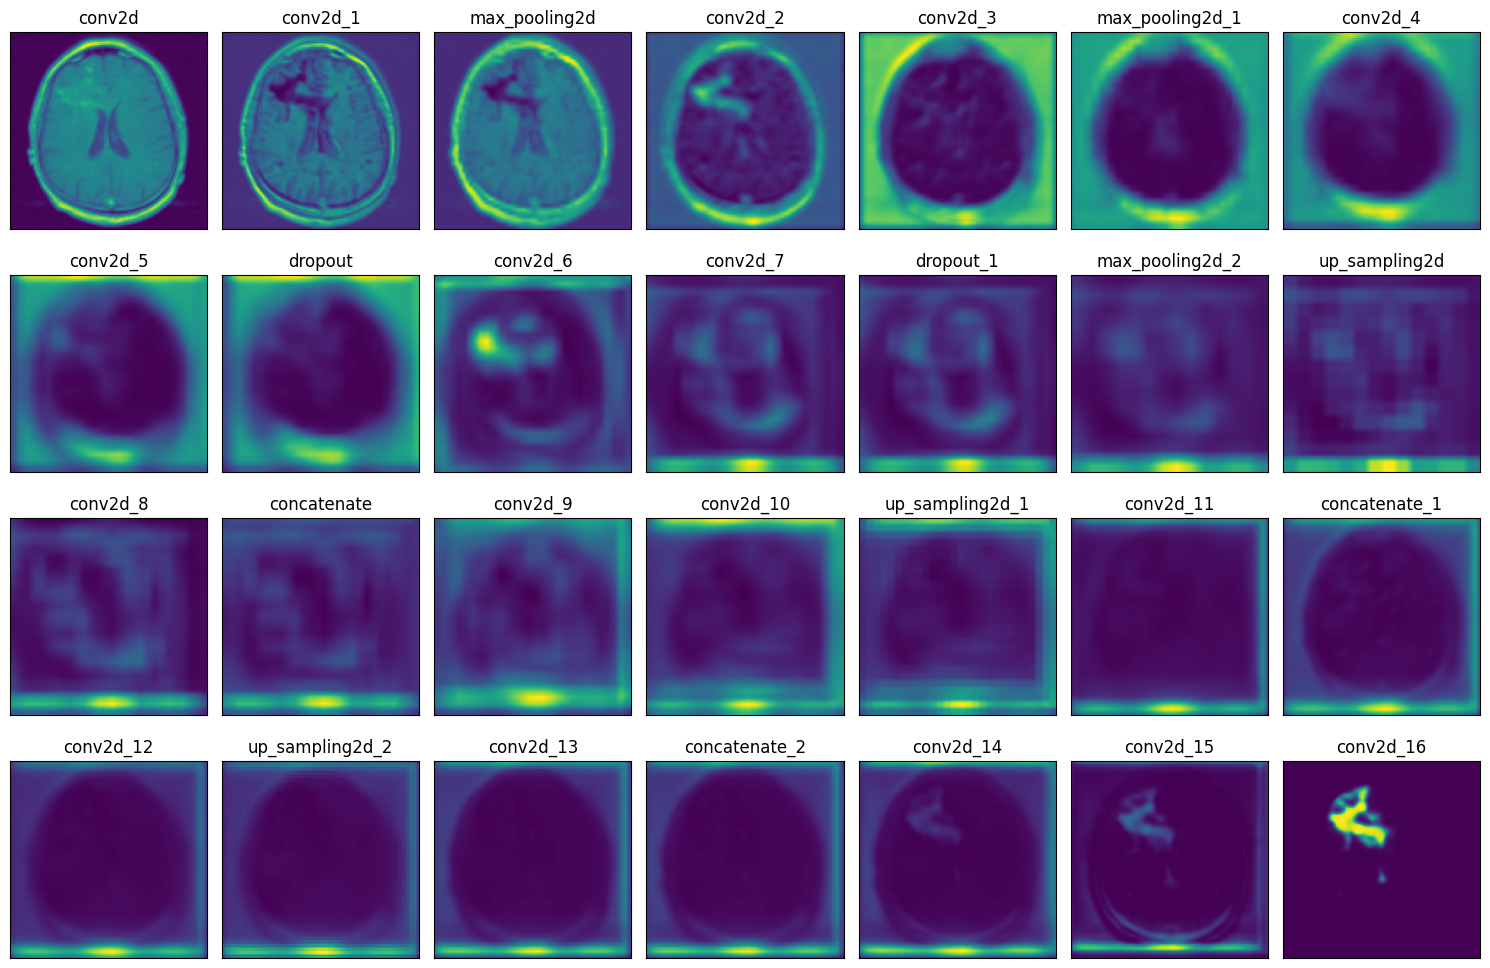

In [54]:
grad_plot_pairs = list(zip(model_layers, feature_maps))

plt.figure(figsize=(15, 10))
for i in range(len(grad_plot_pairs)):
    plt.subplot(4, 7, i + 1)
    plt.imshow(grad_plot_pairs[i][1])
    plt.title(grad_plot_pairs[i][0])

    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()